In [1]:
#P1_Exercise_10.ipynb
#import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob


In [2]:
#1. 
#loading dasta
print("Loading Defect Detection Dataset...")

#function to load images
def load_images_from_folder(folder_path, img_size=(64, 64)):
    """loaod and flatten images from folder"""
    images = []
    for img_path in glob.glob(os.path.join(folder_path, '*.png')):
        img = Image.open(img_path).convert('L')
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0
        images.append(img_array.flatten()) #flatten
    return np.array(images)

#base path for images
base_path = r'C:\Users\siona\Desktop\Data\Info_4000\defect'

#load images
train_good = load_images_from_folder(os.path.join(base_path, 'train', 'good'))
test_good = load_images_from_folder(os.path.join(base_path, 'test', 'good'))
test_defective = load_images_from_folder(os.path.join(base_path, 'test', 'defective'))

#displaying info
print(f"Training (good): {len(train_good)} images")
print(f"Test (good): {len(test_good)}, Test (defective): {len(test_defective)}")

Loading Defect Detection Dataset...
Training (good): 2463 images
Test (good): 52, Test (defective): 48


In [7]:
#2.
#building autoencoder
print("Building AutoEncoder...")

#define model
input_dim = train_good.shape[1]

#define autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(AutoEncoder, self).__init__() #inheritance
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential( #decoder
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    #forward
    def forward(self, x): 
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#create model
model = AutoEncoder(input_dim=input_dim, encoding_dim=32)
criterion = nn.MSELoss() #loss
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer

Building AutoEncoder...


In [4]:
#3. 
#training
print("Training on good images...")

#convert to tensor
X_train = torch.FloatTensor(train_good)

#train
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train) #forward
    loss = criterion(outputs, X_train) #loss 
    loss.backward() 
    optimizer.step() #backprop
    
    #print
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

Training on good images...
Epoch [20/100], Loss: 0.0065
Epoch [40/100], Loss: 0.0039
Epoch [60/100], Loss: 0.0035
Epoch [80/100], Loss: 0.0030
Epoch [100/100], Loss: 0.0018


In [5]:
#4.
#anomaly detection
print("\nDetecting anomalies...")

#convert to tensor
test_data = np.vstack([test_good, test_defective])
test_labels = np.array([0]*len(test_good) + [1]*len(test_defective))
X_test = torch.FloatTensor(test_data)

#evaluate
model.eval()
with torch.no_grad():
    reconstructions = model(X_test) #forward
    mse = torch.mean((X_test - reconstructions) ** 2, dim=1) #mse

#anomaly detection
reconstruction_errors = mse.numpy() #mse
threshold = np.percentile(reconstruction_errors, 95) #95th percentile
predicted_anomalies = reconstruction_errors > threshold #anomalies

#displaying info
print(f"\nThreshold (95th percentile): {threshold:.4f}")
print(f"Predicted anomalies: {np.sum(predicted_anomalies)}")
print(f"Actual defective: {np.sum(test_labels == 1)}")


Detecting anomalies...

Threshold (95th percentile): 0.0098
Predicted anomalies: 5
Actual defective: 48



Visualizing results...


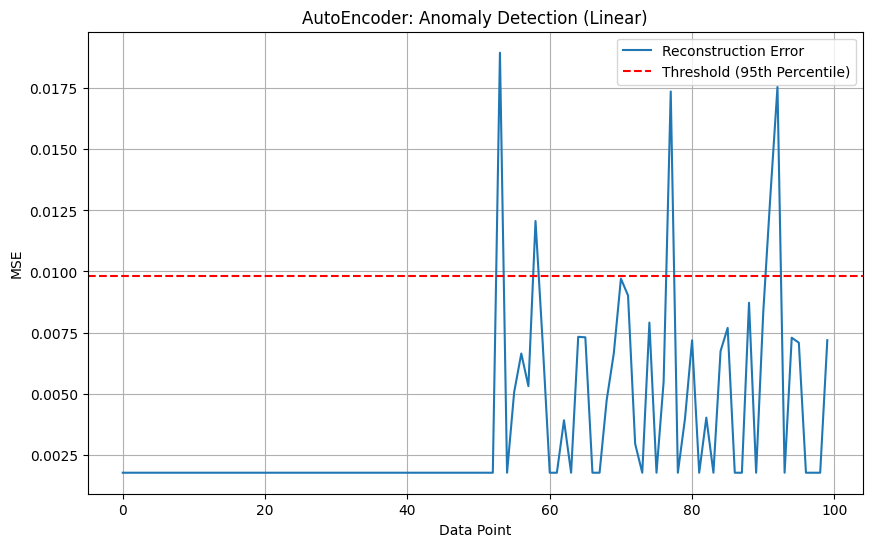

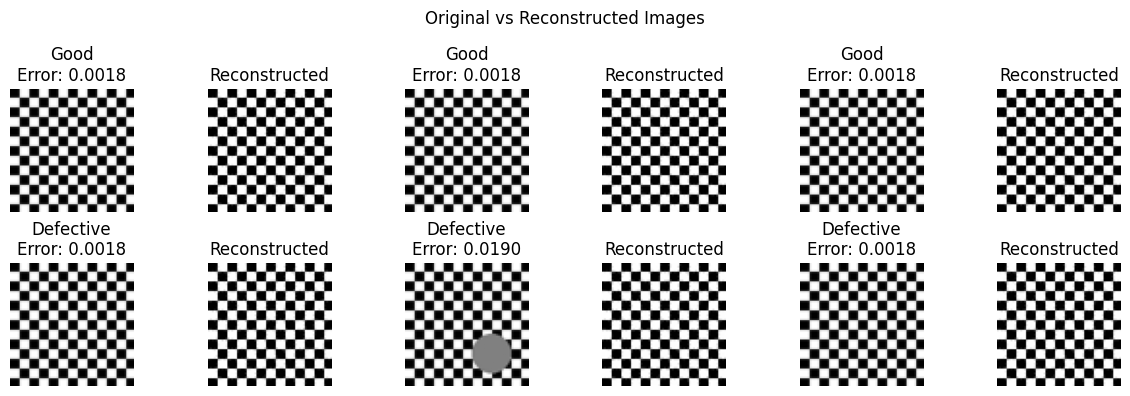

In [6]:
#5.
#visualizing results
print("\nVisualizing results...")

#plot reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(mse.numpy(), label="Reconstruction Error")
plt.axhline(y=np.percentile(mse.numpy(), 95), color='r', linestyle='--', label="Threshold (95th Percentile)")
plt.title("AutoEncoder: Anomaly Detection (Linear)")
plt.xlabel("Data Point")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

#show sample reconstructions
img_size = int(np.sqrt(input_dim))
fig, axes = plt.subplots(2, 6, figsize=(12, 4))

#good samples examples
for i in range(3):
    idx = i
    axes[0, i*2].imshow(test_data[idx].reshape(img_size, img_size), cmap='gray')
    axes[0, i*2].set_title(f'Good\nError: {reconstruction_errors[idx]:.4f}')
    axes[0, i*2].axis('off')
    
    axes[0, i*2+1].imshow(reconstructions[idx].numpy().reshape(img_size, img_size), cmap='gray')
    axes[0, i*2+1].set_title('Reconstructed')
    axes[0, i*2+1].axis('off')

#defective samples examples
for i in range(3):
    idx = len(test_good) + i
    axes[1, i*2].imshow(test_data[idx].reshape(img_size, img_size), cmap='gray')
    axes[1, i*2].set_title(f'Defective\nError: {reconstruction_errors[idx]:.4f}')
    axes[1, i*2].axis('off')
    
    axes[1, i*2+1].imshow(reconstructions[idx].numpy().reshape(img_size, img_size), cmap='gray')
    axes[1, i*2+1].set_title('Reconstructed')
    axes[1, i*2+1].axis('off')

#plot
plt.suptitle('Original vs Reconstructed Images')
plt.tight_layout()
plt.show()
